**Introduction**

This is a Google Colab Notebook which trains a PySlowFast+X3D ensemble model (using pytorchvideo) on a dataset of videos. The dataset's directory should have 3 sub-directories, one for "train", "val", and "test". In each of these directories should be more directories, named with the dataset's classes. Then, within each of these directories should be videos, whose label corresponds to the directory they are placed in (e.g. dataset->train->archery->archery_1.mph).

The "Set-up" section is used for downloading necessary packages and intiliazing variables. Take a look at the variables (such as file paths), and change them accordingly.

The "Class Creation for Dataloaders" section creates the classes/objects necessary for creating and using dataloaders later in the process. Within this section is a commented code block which would change the transform function to one of a resnet. Uncommenting this code block, and changing the model to "make_resnet" in "Model Creation" would use a resnet50 instead.

The "Model Creation" section creates the object that is used as the Lightning Module for the model.

The "Training" section trains the model using the Trainer from Pytorch Lightning.

The "Testing" section tests the model using Trainer.test and a script that manually tests every file in the testing dataset.

The "TSNE" section creates a TSNE.

# Set-up


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
!pip install pytorchvideo
!pip install pytorch_lightning

In [ ]:
import os
import pytorch_lightning
import pytorchvideo.data
import torch.utils.data
import torchvision
import pytorchvideo
import pytorchvideo.transforms
from torch.nn.functional import softmax
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)
import sklearn
#from sklearn.metrics import accuracy_score

In [ ]:
input_dir = '/content/drive/MyDrive/Research/Muscle Video/Datasets/split_workout_videos_v1'
model1_name = "slowfast_r50"
model2_name = "x3d_m"
checkpoint_path = "/content/drive/MyDrive/Research/Muscle Video/Checkpoints/Multilabel/slowfast+x3d"

model1_best_path = '/content/drive/MyDrive/Research/Muscle Video/Checkpoints/Multilabel/slowfast/pretrained/lightning_logs/version_30/checkpoints/epoch=50-step=6528.ckpt'
model2_best_path = '/content/drive/MyDrive/Research/Muscle Video/Checkpoints/Multilabel/x3d_m/pretrained/lightning_logs/version_1/checkpoints/epoch=14-step=1920.ckpt'
num_classes=16
num_labels=11
batch_size = 8
num_workers = 4
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
clip_duration = (num_frames * sampling_rate)/frames_per_second
device=('cuda' if torch.cuda.is_available() else 'cpu')
pretrained=True
learning_rate=0.0001
dropout_rate = 0.6
gamma = 2

model_transform_params  = {
    "x3d_xs": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 4,
        "sampling_rate": 12,
    },
    "x3d_s": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 13,
        "sampling_rate": 6,
    },
    "x3d_m": {
        "side_size": 256,
        "crop_size": 256,
        "num_frames": 16,
        "sampling_rate": 5,
    }
}
transform_params = model_transform_params[model2_name]

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

8

In [ ]:
pred_to_class = {
    0: "triceps",
    1: "lats",
    2: "biceps",
    3: "quads",
    4: "glutes",
    5: "shoulders",
    6: "abs",
    7: "obliques",
    8: "chest",
    9: "lower back",
    10: "hamstrings",
}

id_to_exercise = {
    0: "bench press",
    1: "bicep curl",
    2: "chest fly machine",
    3: "deadlift",
    4: "hip thrust",
    5: "lat pulling",
    6: "lateral raise",
    7: "leg extension",
    8: "leg raises",
    9: "push-up",
    10: "russian twist",
    11: "shoulder press",
    12: "squat",
    13: "t bar row",
    14: "tricep Pushdown",
    15: "tricep dips",
}

class_to_label = {
    0: [8, 5, 0],
    1: [2],
    2: [8],
    3: [4, 9, 10],
    4: [4],
    5: [1, 2],
    6: [5],
    7: [3],
    8: [6],
    9: [8, 5, 0],
    10: [6, 7],
    11: [5],
    12: [3, 4, 10],
    13: [1, 2],
    14: [0],
    15: [0],
}

id_to_label = {
    0: [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    1: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    2: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    3: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],
    4: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    5: [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    6: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    7: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    8: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    9: [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    10: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
    11: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    12: [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    13: [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    14: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    15: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
}

# Class Creation for Dataloaders

In [ ]:
class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """
    def __init__(self):
        super().__init__()

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

slowfast_transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

x3d_transform = ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(transform_params["num_frames"]),
        ]
    ),
)


def post_act(input):
  return softmax(input, dim=1)

'''
from pytorchvideo.models.slowfast import create_slowfast

def make_slowfast():
    return create_slowfast(
        input_channels=(3, 3),
        model_depth=18,
        model_num_class=num_classes,
        norm=nn.BatchNorm3d,
        dropout_rate=dropout_rate,
    )
'''

'\nfrom pytorchvideo.models.slowfast import create_slowfast\n\ndef make_slowfast():\n    return create_slowfast(\n        input_channels=(3, 3),\n        model_depth=18,\n        model_num_class=num_classes,\n        norm=nn.BatchNorm3d,\n        dropout_rate=dropout_rate,\n    )\n'

In [ ]:
from pytorch_lightning.utilities.combined_loader import CombinedLoader

class VideosDataModule(pytorch_lightning.LightningDataModule):

    # Dataset configuration
    _DATA_PATH = input_dir
    _CLIP_DURATION = clip_duration  # Duration of sampled clip for each video
    _BATCH_SIZE = batch_size
    _NUM_WORKERS = num_workers  # Number of parallel processes fetching data

    def train_dataloader(self):
        #Create the train partition from the list of video labels and video paths
        train_dataset = pytorchvideo.data.labeled_video_dataset(
            data_path=os.path.join(self._DATA_PATH, 'train'),
            clip_sampler=pytorchvideo.data.make_clip_sampler("random", self._CLIP_DURATION),
            decode_audio=False,
            transform=slowfast_transform
        )

        return torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self._BATCH_SIZE,
            num_workers=self._NUM_WORKERS
        )

    def val_dataloader(self):
        #Create the validation partition from the list of video labels and video paths
        val_dataset = pytorchvideo.data.labeled_video_dataset(
            data_path=os.path.join(self._DATA_PATH, 'val'),
            clip_sampler=pytorchvideo.data.make_clip_sampler("random", self._CLIP_DURATION),
            decode_audio=False,
            transform=slowfast_transform
        )

        return torch.utils.data.DataLoader(
            val_dataset,
            batch_size=self._BATCH_SIZE,
            num_workers=self._NUM_WORKERS,
        )

    def test_dataloader(self):
        test_dataset = pytorchvideo.data.labeled_video_dataset(
            data_path=os.path.join(self._DATA_PATH, 'test'),
            clip_sampler=pytorchvideo.data.make_clip_sampler("random", self._CLIP_DURATION),
            decode_audio=False,
            transform=slowfast_transform
        )

        test_dataloader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=self._BATCH_SIZE,
            num_workers=self._NUM_WORKERS,
        )

        return test_dataloader

# Model Creation


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchmetrics.classification import MulticlassAccuracy
from torch.nn import Linear
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

mca1 = MulticlassAccuracy(num_classes=num_classes, average='micro', top_k=1)
mca5 = MulticlassAccuracy(num_classes=num_classes, average='micro', top_k=5)

class x3d_VideoClassificationLightningModule(pytorch_lightning.LightningModule):

    def __init__(self):
        super().__init__()

        self.model = torch.hub.load('facebookresearch/pytorchvideo', model2_name, pretrained=True)
        self.model.to(device)
        self.model.blocks[5].proj = Linear(in_features=2048, out_features=num_labels, bias=True)
        self.model.train()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # The model expects a video tensor of shape (B, C, T, H, W), which is the
        # format provided by the dataset
        y_hat = self.model(batch["video"])

        # Compute cross entropy loss, loss.backwards will be called behind the scenes
        # by PyTorchLightning after being returned from this method.

        loss = F.cross_entropy(y_hat, batch["label"])

        # Log the train loss to Tensorboard
        self.log("train_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("train_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("train_accuracy_top_5", acc5.item(), batch_size=batch_size)

        print("train_loss:", loss.item(), "train_accuracy_top_1:", acc1.item(), "train_accuracy_top_5:", acc5.item())

        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self.model(batch["video"])
        loss = F.cross_entropy(y_hat, batch["label"])

        self.log("val_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("val_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("val_accuracy_top_5", acc5.item(), batch_size=batch_size)

        print("val_loss:", loss.item(), "val_accuracy_top_1:", acc1.item(), "val_accuracy_top_5:", acc5.item())

        return loss

    def configure_optimizers(self):
        """
        Setup the Adam optimizer. Note, that this function also can return a lr scheduler, which is
        usually useful for training video models.
        """
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

    def test_step(self, batch, batch_idx):
        y_hat = self.model(batch["video"])
        loss = F.cross_entropy(y_hat, batch["label"])

        # logs metrics for each testing_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("test_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("test_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("test_accuracy_top_5", acc5.item(), batch_size=batch_size)

        softed = post_act(y_hat)
        auc = roc_auc_score(y_true=batch["label"].cpu(), y_score=softed.cpu(), multi_class='ovr', average='micro', labels=np.arange(num_classes))
        self.log("auc", auc, batch_size=batch_size)

        pred_classes = []
        for x in softed:
          class_index = x.topk(k=1).indices
          class_index = class_index[0]
          pred_classes.append(class_index)
        pred_classes = torch.Tensor(pred_classes)

        rpf1 = precision_recall_fscore_support(y_true=batch["label"].cpu(), y_pred=pred_classes.cpu(), beta=1, labels=np.arange(num_classes), average='macro', zero_division=1)
        precision = rpf1[0]
        recall = rpf1[1]
        f1 = rpf1[2]
        self.log("precision", precision, batch_size=batch_size)
        self.log("recall", recall, batch_size=batch_size)
        self.log("f1", f1, batch_size=batch_size)

        print("test_loss:", loss.item(), "test_accuracy_top_1:", acc1.item(), "test_accuracy_top_5:", acc5.item(), "auc:", auc, "precision:", precision, "recall:", recall, "f1:", f1)

        return loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchmetrics.classification import MulticlassAccuracy
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

mca1 = MulticlassAccuracy(num_classes=num_classes, average='micro', top_k=1)
mca5 = MulticlassAccuracy(num_classes=num_classes, average='micro', top_k=5)

class slowfast_VideoClassificationLightningModule(pytorch_lightning.LightningModule):

    def __init__(self):
        super().__init__()

        self.model = torch.hub.load("facebookresearch/pytorchvideo", model=model1_name, pretrained=True)
        self.model.to(device)
        self.model.blocks[6].proj = nn.Linear(in_features=2304, out_features=num_labels, bias=True)
        self.model.train()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # The model expects a video tensor of shape (B, C, T, H, W), which is the
        # format provided by the dataset
        y_hat = self.model(batch["video"])

        # Compute cross entropy loss, loss.backwards will be called behind the scenes
        # by PyTorchLightning after being returned from this method.

        loss = F.cross_entropy(y_hat, batch["label"])

        # Log the train loss to Tensorboard
        self.log("train_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("train_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("train_accuracy_top_5", acc5.item(), batch_size=batch_size)

        #last_layer = self.model.blocks[6].proj
        #embeddings = []

        print("train_loss:", loss.item(), "train_accuracy_top_1:", acc1.item(), "train_accuracy_top_5:", acc5.item())

        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self.model(batch["video"])
        loss = F.cross_entropy(y_hat, batch["label"])

        self.log("val_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("val_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("val_accuracy_top_5", acc5.item(), batch_size=batch_size)

        print("val_loss:", loss.item(), "val_accuracy_top_1:", acc1.item(), "val_accuracy_top_5:", acc5.item())

        return loss

    def configure_optimizers(self):
        """
        Setup the Adam optimizer. Note, that this function also can return a lr scheduler, which is
        usually useful for training video models.
        """
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

    def test_step(self, batch, batch_idx):
        y_hat = self.model(batch["video"])
        loss = F.cross_entropy(y_hat, batch["label"])

        # logs metrics for each testing_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("test_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("test_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("test_accuracy_top_5", acc5.item(), batch_size=batch_size)

        softed = post_act(y_hat)
        auc = roc_auc_score(y_true=batch["label"].cpu(), y_score=softed.cpu(), multi_class='ovr', average='micro', labels=np.arange(num_classes))
        self.log("auc", auc, batch_size=batch_size)

        pred_classes = []
        for x in softed:
          class_index = x.topk(k=1).indices
          class_index = class_index[0]
          pred_classes.append(class_index)
        pred_classes = torch.Tensor(pred_classes)

        rpf1 = precision_recall_fscore_support(y_true=batch["label"].cpu(), y_pred=pred_classes.cpu(), beta=1, labels=np.arange(num_classes), average='macro', zero_division=1)
        precision = rpf1[0]
        recall = rpf1[1]
        f1 = rpf1[2]
        self.log("precision", precision, batch_size=batch_size)
        self.log("recall", recall, batch_size=batch_size)
        self.log("f1", f1, batch_size=batch_size)

        print("test_loss:", loss.item(), "test_accuracy_top_1:", acc1.item(), "test_accuracy_top_5:", acc5.item(), "auc:", auc, "precision:", precision, "recall:", recall, "f1:", f1)

        return loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchmetrics.classification import MultilabelAccuracy, MultilabelAUROC, MultilabelRecall, MultilabelPrecision, MultilabelF1Score

mcaM2 = MultilabelAccuracy(num_labels=num_labels, average='micro')
mcaS = MultilabelAccuracy(num_labels=num_labels, average='none')
roc_auc = MultilabelAUROC(num_labels=num_labels, average="micro")
pre = MultilabelPrecision(num_labels=num_labels, average='macro', threshold=0.5)
rec = MultilabelRecall(num_labels=num_labels, average='macro', threshold=0.5)
f1score = MultilabelF1Score(num_labels=num_labels, average='macro', threshold=0.5)

class VideoClassificationLightningModule(pytorch_lightning.LightningModule):

    def __init__(self):
        super().__init__()

        self.model1 = slowfast_VideoClassificationLightningModule.load_from_checkpoint(model1_best_path)
        self.model1.to(device)
        self.model1.eval()

        self.model2 = x3d_VideoClassificationLightningModule.load_from_checkpoint(model2_best_path)
        self.model2.model.blocks[5].activation = None
        self.model2.to(device)
        self.model2.eval()
        #print(self.model2)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # The model expects a video tensor of shape (B, C, T, H, W), which is the
        # format provided by the dataset
        y_hat = self.model(batch["video"])

        # Compute cross entropy loss, loss.backwards will be called behind the scenes
        # by PyTorchLightning after being returned from this method.

        loss = F.cross_entropy(y_hat, batch["label"])

        # Log the train loss to Tensorboard
        self.log("train_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("train_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("train_accuracy_top_5", acc5.item(), batch_size=batch_size)

        #last_layer = self.model.blocks[6].proj
        #embeddings = []

        print("train_loss:", loss.item(), "train_accuracy_top_1:", acc1.item(), "train_accuracy_top_5:", acc5.item())

        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self.model(batch["video"])
        loss = F.cross_entropy(y_hat, batch["label"])

        self.log("val_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("val_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("val_accuracy_top_5", acc5.item(), batch_size=batch_size)

        print("val_loss:", loss.item(), "val_accuracy_top_1:", acc1.item(), "val_accuracy_top_5:", acc5.item())

        return loss

    def configure_optimizers(self):
        """
        Setup the Adam optimizer. Note, that this function also can return a lr scheduler, which is
        usually useful for training video models.
        """
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

    def test_step(self, batch, batch_idx):

        slowfast_data = batch["video"]
        x3d_data = batch["video"][1]

        y_hat1 = self.model1(slowfast_data)
        y_hat2 = self.model2(x3d_data)

        y_hat = []
        for x in range(0, y_hat1.shape[0]):
          temp = []
          for y in range(0, 11):
            val = 0.75*y_hat1[x][y] + 0.25*y_hat2[x][y]
            temp.append(val)
          y_hat.append(temp)

        y_hat = torch.Tensor(y_hat)

        new_label = torch.tensor([id_to_label[i.item()] for i in batch["label"]])

        loss = F.cross_entropy(y_hat.cpu(), new_label.cpu())
        #loss = torch.Tensor(0)

        # logs metrics for each testing_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("test_loss", loss.item(), batch_size=batch_size)

        accM2 = mcaM2(y_hat.cpu(), new_label.cpu())
        self.log("test_accuracy_micro", accM2.item(), batch_size=batch_size)

        new_label = new_label.type(torch.IntTensor)

        auc = roc_auc(y_hat.cpu(), new_label.cpu())
        self.log("auc", auc.item(), batch_size=batch_size)

        precision = pre(y_hat.cpu(), new_label.cpu())
        recall = rec(y_hat.cpu(), new_label.cpu())
        f1 = f1score(y_hat.cpu(), new_label.cpu())

        self.log("precision", precision.item(), batch_size=batch_size)
        self.log("recall", recall.item(), batch_size=batch_size)
        self.log("f1", f1.item(), batch_size=batch_size)

        print("test_loss:", loss.item(), "test_accuracy_micro:", accM2.item(), "auc:", auc.item(), "precision:", precision.item(), "recall", recall.item(), "f1", f1.item())

        return loss

# Training

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

early_stopping_callbacks = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=True, mode="min")

In [ ]:
classification_module = VideoClassificationLightningModule()
data_module = VideosDataModule()
trainer = pytorch_lightning.Trainer(
    default_root_dir=checkpoint_path,
    max_epochs=30,
    accelerator="auto",
    devices="auto",
    strategy='auto',
    enable_checkpointing=True,
    logger=True,
)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
torch.set_float32_matmul_precision('medium')

In [ ]:
trainer.fit(classification_module, data_module, ckpt_path='/content/drive/MyDrive/Research/Muscle Video/Checkpoints/Split/Pretrained/slowfast_r101/lightning_logs/version_5/checkpoints/epoch=28-step=3754.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Research/Muscle Video/Checkpoints/Split/Pretrained/slowfast_r101/lightning_logs/version_5/checkpoints/epoch=28-step=3754.ckpt


RuntimeError: ignored

# Testing


In [ ]:
trainer.test(model=classification_module, datamodule=data_module, verbose=True)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

test_loss: 1.962888479232788 test_accuracy_micro: 0.9545454382896423 auc: 0.9951738119125366 precision: 0.8030303716659546 recall 0.9090909957885742 f1 0.8333333730697632
test_loss: 1.4779531955718994 test_accuracy_micro: 0.9659090638160706 auc: 0.9942084550857544 precision: 0.5833333134651184 recall 0.5909091234207153 f1 0.5748917460441589
test_loss: 2.45849347114563 test_accuracy_micro: 0.9659090638160706 auc: 0.9861111640930176 precision: 0.7272727489471436 recall 0.6212121248245239 f1 0.6606060266494751
test_loss: 1.699234127998352 test_accuracy_micro: 0.9772727489471436 auc: 1.0 precision: 0.7272727489471436 recall 0.7272727489471436 f1 0.7272727489471436
test_loss: 1.5587481260299683 test_accuracy_micro: 1.0 auc: 1.0 precision: 0.6363636255264282 recall 0.6363636255264282 f1 0.6363636255264282
test_loss: 1.3723828792572021 test_accuracy_micro: 0.9772727489471436 auc: 1.0 precision: 0.41363635659217834 recall 0.4545454680919647 f1 0.43145743012428284
test_loss: 1.7734178304672241 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            auc            │    0.9910013675689697     │
│            f1             │    0.6528170704841614     │
│         precision         │    0.6493113040924072     │
│          recall           │    0.6713154911994934     │
│    test_accuracy_micro    │    0.9742595553398132     │
│         test_loss         │    2.0968172550201416     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.0968172550201416,
  'test_accuracy_micro': 0.9742595553398132,
  'auc': 0.9910013675689697,
  'precision': 0.6493113040924072,
  'recall': 0.6713154911994934,
  'f1': 0.6528170704841614}]

# TSNE

In [ ]:
TSNE_model = VideoClassificationLightningModule.load_from_checkpoint(best_checkpoint_path)
TSNE_model.to('cpu')
TSNE_model.model.blocks.pop(6)
TSNE_model.eval()
print("done")

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


done


In [ ]:
from sklearn.manifold import TSNE
import random
import matplotlib.pyplot as plt

In [ ]:
seed = 10
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
labels = []
features = None

In [ ]:
thingy = data_module.test_dataloader()
for batch in thingy:
  x = batch["video"]
  labels += batch["label"]

  with torch.no_grad():
    output = TSNE_model(x)
    output = torch.flatten(output, 1)

  current_features = output.cpu().numpy()

  if features is not None:
    features = np.concatenate((features, current_features))
  else:
    features = current_features

In [ ]:
tsne = TSNE(n_components=2).fit_transform(features)

In [ ]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [ ]:
colors_per_class = {
    0: [254, 202, 87],
    1: [255, 107, 107],
    2: [10, 189, 227],
    3: [255, 159, 243],
    4: [16, 172, 132],
    5: [128, 80, 128],
    6: [87, 101, 116],
    7: [52, 31, 151],
    8: [0, 0, 0],
    9: [100, 100, 255],
    10: [128, 109, 84],
    11: [15, 245, 218],
    12: [242, 10, 21],
    13: [242, 10, 149],
    14: [40, 242, 0],
    15: [255, 153, 10]
}

<ipython-input-45-885392fecd81>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  color = np.array(colors_per_class[label], dtype=np.float) / 255
<ipython-input-45-885392fecd81>:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(current_tx, current_ty, c=color, label=label, s=15)


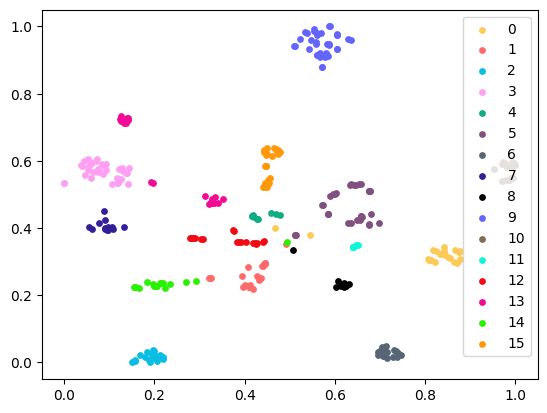

In [ ]:
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)

# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format
    color = np.array(colors_per_class[label], dtype=np.float) / 255

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label, s=15)

# build a legend using the labels we set previously
ax.legend(loc='best')

# finally, show the plot
plt.show()